## 0. Goal
Train the VAE on chopped spectrogram dataset <br>
Differ from v1: train only on calls

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [6]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8]]
# what syllable to analyze, empty means all syllable with annotation
syl = ['v']
# what spectroram dataset to use, see ZZp1_makeSpec_traj_v1.ipynb
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what chopped dataset to use
chop_suffix = 'Chop2'
chop_run = 'traj_chop_32_1_32'
# save to what subfolder
vae_suffix = 'VAE2'
rn = chop_run

In [7]:
X_SHAPE = (128, 128)

## 2. Loop through birds, train the VAE

Processing for pair5RigCCU29 traj_chop_32_1_32...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/VAE2/traj_chop_32_1_32
(100000, 16)
Training: epochs 0 to 50
Training set: 100000
Test set: 100000


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 1924.4438
Epoch: 1 Average loss: 429.7330
Epoch: 2 Average loss: 356.4532
Epoch: 3 Average loss: 320.1112
Epoch: 4 Average loss: 297.8295
Epoch: 5 Average loss: 283.0105
Epoch: 6 Average loss: 274.3432
Epoch: 7 Average loss: 265.7524
Epoch: 8 Average loss: 260.0960
Epoch: 9 Average loss: 254.6639
Epoch: 10 Average loss: 250.1176
Epoch: 11 Average loss: 247.0409
Epoch: 12 Average loss: 243.2213
Epoch: 13 Average loss: 239.6410
Epoch: 14 Average loss: 237.1019
Epoch: 15 Average loss: 233.6827
Epoch: 16 Average loss: 231.2779
Epoch: 17 Average loss: 227.5202
Epoch: 18 Average loss: 226.3625
Epoch: 19 Average loss: 224.1382
Epoch: 20 Average loss: 221.6184
Epoch: 21 Average loss: 218.9650
Epoch: 22 Average loss: 218.1039
Epoch: 23 Average loss: 215.8788
Epoch: 24 Average loss: 213.6905
Epoch: 25 Average loss: 211.8265
Epoch: 26 Average loss: 210.7464
Epoch: 27 Average loss: 209.0832
Epoch: 28 Average loss: 206.7962
Epoch: 29 Average loss: 205.7853
Epoch: 30 Average l

1563it [01:52, 13.88it/s]


(100000, 32)


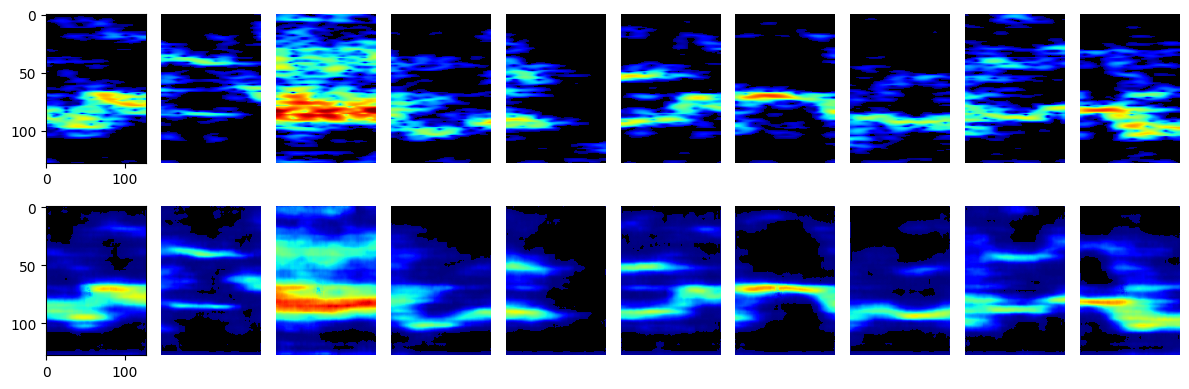

In [8]:
# loop through birds
# for bi in range(1, len(birdIDs)):
for bi in range(1):
    bd = birdIDs[bi]
    fd_save = os.path.join(fd_data, bd, 'Traj', vae_suffix, rn)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)

    print(f'Processing for {bd} {rn}...')
    print(f'Save results to {fd_save}')
    ## load spectrograms and meta info
    fn_spec = os.path.join(fd_data, bd, 'Traj', chop_suffix, f'{bd}.{chop_run}.chop.h5')
    fn_info = os.path.join(fd_data, bd, 'Traj', chop_suffix, f'{bd}.{chop_run}.chop.info.csv')

    info = pd.read_csv(fn_info, index_col=0)

    print(info.shape)

    ## train VAE network
    # create dataloader from h5 file
    train_data = vae_goffinet.SpecDataset(fn_spec)
    # set a random seed
    g = torch.Generator()
    g.manual_seed(42)
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
    loaders = {'train':train_dataloader, 'test':train_dataloader}

    # init VAE model then train
    model = vae_goffinet.VAE(save_dir=fd_save)
    model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

    # save model
    fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
    model.save_state(fn_model)

    ## Obtain latent representation
    train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

    # loop through dataloader, obtain model latent space
    latent_m = np.zeros((info.shape[0], 32))
    latent_d = np.zeros((info.shape[0], 32))
    recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
    model.eval()
    count = 0
    for i, data in tqdm.tqdm(enumerate(train_dataloader)):
        data = data.to('cuda:0')
        with torch.no_grad():
            _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
            a = rec.shape[0]
            latent_m[count:(count+a),:] = mu
            latent_d[count:(count+a),:] = d
            recon[count:(count+a),:,:] = rec
            count += a

    # save the latent representations
    fn_latentM = os.path.join(fd_save, 'latentM.csv')
    np.savetxt(fn_latentM, latent_m, delimiter=',')
    fn_latentD = os.path.join(fd_save, 'latentD.csv')
    np.savetxt(fn_latentD, latent_d, delimiter=',')
    print(latent_m.shape)

    ## check recontruction accuracy (optional)
    # plot some random samples
    fig, ax = plt.subplots(2, 10, figsize=[12,4])
    random.seed(1118)
    random_i = random.sample(list(range(recon.shape[0])), 10)
    with h5py.File(fn_spec, 'r') as file:
        for ii in range(10):
            spec = train_data[random_i[ii],:,:].numpy()
            ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            spec = recon[random_i[ii],:,:]
            ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
            if ii>0:
                ax[0][ii].axis('off')
                ax[1][ii].axis('off')
    plt.tight_layout()
    # save fig
    fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
    fig.savefig(fn_fig)
